#Settings

In [ ]:
BatchSize = 8
train_path = '/content/content/train_jpeg'
eval_path = '/content/content/eval_jpeg'
image_Height = 256
image_Width = 256
downSample = 4

#Model
srb = 2
hd_u = 32

#Loss
grd = True #gradient

#Optimizer
learning_rate = 0.01
epochs = 500
beta1 = 0.9

#loss tracking
training_loss = []
eval_loss = []


#Load Image from drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Create dataset

In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class MyDataset(Dataset):
  def __init__(self , sr_dir, blur_dir):
    self.sr_dir = sr_dir
    self.blur_dir = blur_dir
    self.toTensor = transforms.ToTensor()

  def __len__(self):
    return len(os.listdir(self.sr_dir))

  def __getitem__(self , idx):
    img_path = os.path.join(self.sr_dir , "%d.png" % (idx+1))
    sr_img = self.toTensor(Image.open(img_path).convert('RGB')) #center the image
    img_path = os.path.join(self.blur_dir , "%d.png" % (idx+1))
    blur_img = self.toTensor(Image.open(img_path).convert('RGB'))


    return sr_img, blur_img

In [ ]:
sr_dir = "/content/gdrive/MyDrive/imgs"
blur_dir = "/content/gdrive/MyDrive/blur_imgs"
dataset = MyDataset(sr_dir, blur_dir)

In [ ]:
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1], generator=generator1)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size = BatchSize , shuffle = True,)
val_loader = torch.utils.data.DataLoader(val_dataset , batch_size = BatchSize , shuffle = True,)
test_loader = torch.utils.data.DataLoader(test_dataset , batch_size = BatchSize , shuffle = True,)

#Create dataset old

In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
import torchvision
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class MyDataset(Dataset):
  def __init__(self , img_dir , transform = None):
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(os.listdir(self.img_dir))

  def __getitem__(self , idx):
    img_path = os.path.join(self.img_dir , "screenshot%05d.png" % idx)
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)
    return img

In [ ]:
class resizeNormalize(object):
    def __init__(self, size, mask=False, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.mask = mask

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img_tensor = self.toTensor(img)
        if self.mask:
            mask = img.convert('L')
            thres = np.array(mask).mean()
            mask = mask.point(lambda x: 0 if x > thres else 255)
            mask = self.toTensor(mask)
            img_tensor = torch.cat((img_tensor, mask), 0)
        return img_tensor

class alignCollate_syn(object):
    def __init__(self, imgH=64, imgW=256, down_sample_scale=4, keep_ratio=False, min_ratio=1, mask=False):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio
        self.down_sample_scale = down_sample_scale
        self.mask = mask

    def __call__(self, batch):
        #images = zip(*batch)
        images = batch
        imgH = self.imgH
        imgW = self.imgW
        transform = resizeNormalize((imgW, imgH), self.mask)
        transform2 = resizeNormalize((imgW // self.down_sample_scale, imgH // self.down_sample_scale), self.mask)

        images_hr = [transform(image) for image in images]
        images_hr = torch.cat([t.unsqueeze(0) for t in images_hr], 0)

        images_lr = [image.resize((image.size[0]//self.down_sample_scale, image.size[1]//self.down_sample_scale), Image.BICUBIC) for image in images]
        images_lr = [transform2(image) for image in images_lr]
        images_lr = torch.cat([t.unsqueeze(0) for t in images_lr], 0)

        return images_hr, images_lr

In [ ]:
# train_path = '/content/self_train_1'
# train_dataset = MyDataset(train_path)

In [ ]:
# train_loader = torch.utils.data.DataLoader(
#     train_dataset , batch_size = BatchSize , shuffle = True , collate_fn = alignCollate_syn(imgH = image_Height, imgW = image_Width, down_sample_scale=downSample, mask = True) , drop_last = True
# )

#Building Models

In [ ]:
import math
import time
import torch.nn.functional as F
from collections import OrderedDict
import sys
from torch.nn import init
from IPython import embed

In [ ]:
class GruBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(GruBlock, self).__init__()
    assert out_channels % 2 == 0
    self.conv1 = nn.Conv2d(in_channels , out_channels , kernel_size=1 , padding = 0)
    self.gru = nn.GRU(out_channels , out_channels // 2 , bidirectional = True , batch_first = True)

  def forward(self , x):
    x = self.conv1(x)
    x = x.permute(0 , 2 , 3 ,1).contiguous()
    b = x.size()
    x = x.view(b[0] * b[1], b[2], b[3])
    x , _ = self.gru(x)
    x = x.view(b[0] , b[1] , b[2] , b[3])
    x = x.permute(0 , 3 , 1 , 2)
    return x

In [ ]:
class mish(nn.Module):
  def __init__(self,):
    super(mish , self).__init__()
    self.activated = True

  def forward(self , x):
    if self.activated:
      x = x * (torch.tanh(F.softplus(x)))
    return x

In [ ]:
class RecurrentResidualBlock(nn.Module):
  def __init__(self, channels):
    super(RecurrentResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size = 3 , padding = 1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.gru1 = GruBlock(channels , channels)
    self.prelu = mish()
    self.conv2 = nn.Conv2d(channels , channels , kernel_size=3 , padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
    self.gru2 = GruBlock(channels , channels)

  def forward(self , x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    residual = self.gru1(residual.transpose(-1 , -2)).transpose(-1,-2)

    return self.gru2(x+residual)

In [ ]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels , upscale):
    super(UpsampleBlock , self).__init__()
    self.conv = nn.Conv2d(in_channels , in_channels * upscale ** 2 , kernel_size=3 , padding=1)
    self.pixel_shuffle = nn.PixelShuffle(upscale)
    self.prelu = mish()

  def forward(self , x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [ ]:
class TSRN(nn.Module):
  def __init__(self , scale_factor=4 , width=128 , height=32 , STN=False , srb_nums=5, mask=True, hidden_units=32 ):
    super(TSRN, self).__init__()
    in_planes = 3
    if mask:
      in_planes = 4

    # assert math.log(scale_factor,2)%1 == 0
    # upsample_block_num = int(math.log(scale_factor,2))


    self.block1 = nn.Sequential(
        nn.Conv2d(in_planes , 2* hidden_units , kernel_size=9 , padding = 4),
        nn.PReLU()
    )
    self.srb_nums = srb_nums

    srb_blocks = [RecurrentResidualBlock(2*hidden_units) for _ in range(srb_nums)]
    srb_blocks += [nn.Conv2d(2*hidden_units , 2*hidden_units , kernel_size = 3 , padding=1),nn.BatchNorm2d(2*hidden_units)]
    self.srb_blocks = nn.Sequential(*srb_blocks)
    # for i in range(srb_nums):
    #   setattr(self , 'block%d' % (i+2), RecurrentResidualBlock(2*hidden_units))

    # setattr(self , 'block%d' % (srb_nums+2),
    #         nn.Sequential(
    #             nn.Conv2d(2*hidden_units , 2*hidden_units , kernel_size = 3 , padding=1),
    #             nn.BatchNorm2d(2*hidden_units)
    #         ))

    # block_ = [UpsampleBlock(2*hidden_units , 2) for _ in range(upsample_block_num)]
    # block_.append(nn.Conv2d(2*hidden_units , in_planes ,  kernel_size=9 , padding = 4))
    # self.upsample_blocks = nn.Sequential(*block_)
    self.upsample_blocks = nn.Conv2d(2*hidden_units , in_planes ,  kernel_size=9 , padding = 4)
    #setattr(self, 'block%d' % (srb_nums+3) , nn.Sequential(*block_))

    # self.tps_inputsize = [32, 64]
    # tps_outputsize = [height//scale_factor, width//scale_factor]
    # num_control_points = 20
    # tps_margins = [0.05, 0.05]
    # self.stn = STN
    # if self.stn:
    #     self.tps = TPSSpatialTransformer(
    #         output_image_size=tuple(tps_outputsize),
    #         num_control_points=num_control_points,
    #         margins=tuple(tps_margins))

    #     self.stn_head = STNHead(
    #         in_planes=in_planes,
    #         num_ctrlpoints=num_control_points,
    #         activation='none')

  def forward(self , x):
    # if self.stn and self.training:
    #   x = F.interpolate(x, self.tps_inputsize, mode='bilinear', align_corners=True)
    #   _, ctrl_points_x = self.stn_head(x)
    #   x, _ = self.tps(x, ctrl_points_x)
    block = self.block1(x)
    block2 = self.srb_blocks(block)
    output = torch.tanh(self.upsample_blocks(block+block2))
    # for i in range(self.srb_nums + 1):
    #   block[str(i+2)] = getattr(self, 'block%d' % (i+2))(block[str(i+1)])

    #block[str(self.srb_nums + 3)] = getattr(self, 'block%d' % (self.srb_nums + 3))((block['1'] + block[str(self.srb_nums + 2)]))
    #output = torch.tanh(block[str(self.srb_nums + 3)])

    #print(block['1'].shape, output.shape)

    return output

#Loss

In [ ]:
class GradientPriorLoss(nn.Module):
  def __init__(self , ):
    super(GradientPriorLoss , self).__init__()
    self.func = nn.L1Loss()

  def forward(self , out_images , target_images):
    map_out = self.gradient_map(out_images)
    map_target = self.gradient_map(target_images)
    return self.func(map_out , map_target)

  @staticmethod
  def gradient_map(x):
    batch_size , channel , h_x , w_x = x.size()
    r = F.pad(x , (0,1,0,0))[: , : , : , 1:]
    l = F.pad(x , (1,0,0,0))[: , : , : , :w_x]
    t = F.pad(x , (0,0,1,0))[: , : , :h_x , :]
    b = F.pad(x , (0,0,0,1))[: , : , 1: , :]
    xgrad = torch.pow(torch.pow((r-l)*0.5 , 2) + torch.pow((t-b)*0.5 , 2)+1e-6 , 0.5)
    return xgrad

In [ ]:
class ImageLoss(nn.Module):
  def __init__(self , gradient = True , loss_weight = [20 , 1e-4]):
    super(ImageLoss , self).__init__()
    self.mse = nn.MSELoss()
    if gradient:
      self.GPLoss = GradientPriorLoss()
    self.gradient = gradient
    self.loss_weight = loss_weight

  def forward(self , out_images, target_images):
    if self.gradient:
      loss = self.loss_weight[0] * self.mse(out_images , target_images) + \
             self.loss_weight[1] * self.GPLoss(out_images[: , :3 , : , :], target_images[: , :3 , : , :])
    else:
      loss = self.loss_weight[0] * self.mse(out_images , target_images)
    return loss


#Training New

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
def train(model):
  model = model.to(device)
  image_crit = ImageLoss(gradient=grd, loss_weight=[1 , 1e-2])
  image_crit = image_crit.to(device)
  optimizer_G = torch.optim.Adam(model.parameters() , lr=1e-4 , betas=(beta1,0.999))
  scheduler = CosineAnnealingLR(optimizer_G, T_max=300, eta_min=0)

  for epoch in range(1,31):
    print("Number of epoch:" , epoch)
    train_loss = 0
    for j, data in (enumerate(train_loader)):
      model.train() #verify that model is training instead of evaluating
      optimizer_G.zero_grad()

      images_hr , images_lr = data #[16,3,256,256]
      images_lr = images_lr.to(device)
      images_hr = images_hr.to(device)
      image_sr = model(images_lr)

      loss_im = image_crit(image_sr , images_hr).mean()

      loss_im.backward()

      optimizer_G.step()

      #torch.cuda.empty_cache()
      if j%30==0:
        print("Loss check: ", loss_im.item())

      train_loss += loss_im.item()*len(data)
    scheduler.step()

    print("Train Loss: ", train_loss/len(train_dataset))

    if epoch%5==0:
      with torch.no_grad():
        if epoch==5:
          for j, data in (enumerate(val_loader)):
            sample_hr, sample_lr = data
            sample_hr, sample_lr = sample_hr.to(device), sample_lr.to(device)
            break

          trans = transforms.ToPILImage()
          img = trans(sample_lr[0])
          img = img.save("/content/gdrive/MyDrive/sample_imgs/same100_lr_%d.png" % epoch)
          img = trans(sample_hr[0])
          img = img.save("/content/gdrive/MyDrive/sample_imgs/same100_hr_%d.png" % epoch)

        model.eval()
        output = model(sample_lr)
        img = trans(output[0]) #reverse the preprocessing
        img = img.save("/content/gdrive/MyDrive/sample_imgs/same100_trans_%d.png" % epoch)

        validation_loss = 0
        for j, data in (enumerate(val_loader)):
          model.eval()
          images_hr, images_lr = data
          images_lr = images_lr.to(device)
          images_hr = images_hr.to(device)
          image_sr = model(images_lr)

          loss_im = image_crit(image_sr , images_hr).mean() * 100
          validation_loss += loss_im.item()*len(data)

        print("Validation Loss: ", validation_loss/len(val_dataset))
        torch.save(model.state_dict(), "/content/gdrive/MyDrive/model_ckpt/100_%d.ckpt" % epoch)


In [ ]:
model = TSRN(scale_factor=1 , width=image_Width , height=image_Height , STN=False , srb_nums=srb , mask=False , hidden_units=hd_u)

In [ ]:
train(model)

Number of epoch: 1
Loss check:  1.0117002725601196
Loss check:  0.04881472885608673
Loss check:  0.03950003162026405
Train Loss:  0.021390266716480255
Number of epoch: 2
Loss check:  0.034241095185279846
Loss check:  0.033878426998853683
Loss check:  0.03087824583053589
Train Loss:  0.00881199258246592
Number of epoch: 3
Loss check:  0.033622778952121735
Loss check:  0.027690276503562927
Loss check:  0.02583080157637596
Train Loss:  0.007538004985877446
Number of epoch: 4
Loss check:  0.026255296543240547
Loss check:  0.026182644069194794
Loss check:  0.025343991816043854
Train Loss:  0.006527264591838632
Number of epoch: 5
Loss check:  0.025357229635119438
Loss check:  0.022532615810632706
Loss check:  0.021797195076942444
Train Loss:  0.005883581515933786
Validation Loss:  0.5568509435653687
Number of epoch: 6
Loss check:  0.022082192823290825
Loss check:  0.02146213687956333
Loss check:  0.02018149569630623
Train Loss:  0.005359854506594794
Number of epoch: 7
Loss check:  0.02177283

In [ ]:
for j, data in (enumerate(train_loader)):
  images_hr, images_lr = data
  images_lr = images_lr.to(device)
  break

model.eval()
trans = transforms.ToPILImage()
img = trans(images_lr[0]) #reverse the preprocessing
img = img.save("hi.png")

output = model(images_lr)
img = trans(output[0]) #reverse the preprocessing
img = img.save("hi1.png")

#Training

In [ ]:
def eval(model):
  eval_dataset = MyDataset(eval_path)
  eval_loader = torch.utils.data.DataLoader(
      eval_dataset, batch_size = BatchSize, shuffle = True, collate_fn = alignCollate_syn(imgH = image_Height, imgW= image_Width, down_sample_scale=downSample, mask = True), drop_last = True
  )

  image_crit = ImageLoss(gradient=grd, loss_weight=[1 , 1e-4])
  image_crit = image_crit.to(device)

  loss_list = []

  model.eval()
  for j, data in (enumerate(eval_loader)):
    for p in model.parameters():
      p.requires_grad = False

    images_hr , images_lr = data
    images_lr = images_lr.to(device)
    images_hr = images_hr.to(device)

    images_sr = model(images_lr)
    loss_im_eval = image_crit(images_sr,images_hr).mean() * 100
    loss_list.append(loss_im_eval.item())
    torch.cuda.empty_cache()

  eval_loss.append(sum(loss_list)/len(loss_list))


In [ ]:
def train():
  # model = TSRN(scale_factor=downSample , width=image_Width , height=image_Height , STN=False , srb_nums=srb , mask=True , hidden_units=hd_u)
  # model = model.to(device)
  image_crit = ImageLoss(gradient=grd, loss_weight=[1 , 1e-2])
  image_crit = image_crit.to(device)
  optimizer_G = torch.optim.Adam(model.parameters() , lr=learning_rate , betas=(beta1,0.999))

  for epoch in range(5):
    print("Number of epoch:" , epoch)
    for j, data in (enumerate(train_loader)):
      # model.train() #verify that model is training instead of evaluating

      # for p in model.parameters():
      #   p.requires_grad = True
      iters = len(train_loader) * epoch + j + 1

      images_hr , images_lr = data
      print(images_hr.shape, images_lr.shape)

      images_lr = images_lr.to(device)
      images_hr = images_hr.to(device)

      image_sr = model(images_lr)
      loss_im = image_crit(image_sr , images_hr).mean() * 100

      optimizer_G.zero_grad()
      loss_im.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
      optimizer_G.step()

      torch.cuda.empty_cache()

      if j % 200 == 0:
        print("Loss: ", loss_im)
        training_loss.append(loss_im.item())
        eval(model)

  torch.save(model.state_dict(), 'TextZoom_jpeg_20.pkl')



In [ ]:
torch.cuda.empty_cache()

In [ ]:
train()

Number of epoch: 0
Loss:  tensor(0.3407, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2385, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2926, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.3806, device='cuda:0', grad_fn=<MulBackward0>)
Number of epoch: 1
Loss:  tensor(0.2375, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2230, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2616, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.4981, device='cuda:0', grad_fn=<MulBackward0>)
Number of epoch: 2
Loss:  tensor(0.2680, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2108, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2186, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2472, device='cuda:0', grad_fn=<MulBackward0>)
Number of epoch: 3
Loss:  tensor(0.2306, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2207, device='cuda:0', grad_fn=<MulBackward0>)
Loss:  tensor(0.2104, device='cuda:0', gra

In [ ]:
!mv "TextZoom_jpeg_20.pkl" "/content/gdrive/MyDrive/UROP/TextZoom_Resource"

#Denoising

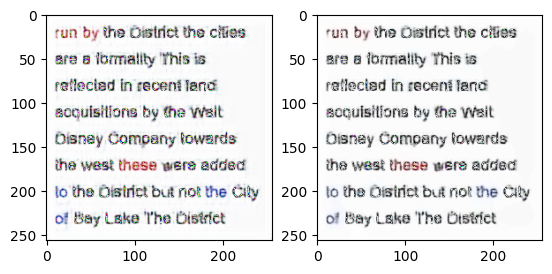

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('/content/gdrive/MyDrive/sample_imgs/same5_trans_15.png')
dst = cv.fastNlMeansDenoisingColored(img,10,10,10,7,21)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

#Evaluation

In [ ]:
print(training_loss)

[0.3407200276851654, 0.23846390843391418, 0.292585551738739, 0.38058358430862427, 0.23746195435523987, 0.22299450635910034, 0.26159611344337463, 0.4981400966644287, 0.26797497272491455, 0.2107529491186142, 0.21859526634216309, 0.24718481302261353, 0.23062452673912048, 0.2207319438457489, 0.2104347050189972, 0.2807972729206085, 0.21538051962852478, 0.2227843999862671, 0.2705560028553009, 0.232627272605896]


In [ ]:
print(eval_loss)

[0.7288363056798135, 0.30718324597804775, 0.24100508300527448, 0.3431440947517272, 0.2529895533957789, 0.2433093315170657, 0.241759616521097, 0.4990884277128404, 0.2851216908424131, 0.22811326360510242, 0.2830749094005554, 0.27848881218702565, 0.22867049565238337, 0.2232264131307602, 0.2243612843655771, 0.24536622700191313, 0.25195197256342056, 0.23516180919062707, 0.25008633973137023, 0.4217529373784219]


In [ ]:
training_loss = [0.3407200276851654, 0.23846390843391418, 0.292585551738739, 0.38058358430862427]
eval_loss = [0.7288363056798135, 0.30718324597804775, 0.24100508300527448, 0.3431440947517272]

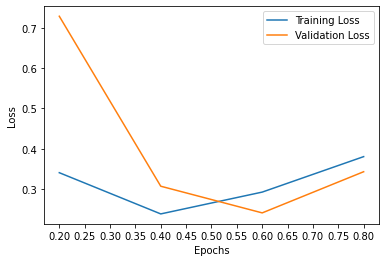

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.linspace(1, len(training_loss) , len(training_loss))/5, training_loss)
plt.plot(np.linspace(1, len(eval_loss) , len(eval_loss))/5, eval_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.locator_params(axis='x', nbins=20)
plt.legend(['Training Loss', 'Validation Loss'])
plt.savefig('result.png')
plt.show()

#Demonstration

In [ ]:
model_eval = TSRN(scale_factor=downSample , width=image_Width , height=image_Height , STN=False , srb_nums=srb , mask=True , hidden_units=hd_u)
model_eval.load_state_dict(torch.load('gdrive/MyDrive/UROP/TextZoom_Resource/TextZoom_jpeg_20.pkl'))

<All keys matched successfully>

In [ ]:
model_eval = model_eval.to(device)

In [ ]:
eval_img = Image.open("/content/content/eval_jpeg/screenshot00053.jpeg")
eval_img = eval_img.resize((image_Height // downSample, image_Width // downSample) , Image.BICUBIC)
img_tensor = transforms.ToTensor()(eval_img)

#add mask
mask = eval_img.convert('L')
thres = np.array(mask).mean()
mask = mask.point(lambda x: 0 if x > thres else 255)
mask = transforms.ToTensor()(mask)
img_tensor = torch.cat((img_tensor, mask), 0)

img_lr = img_tensor.unsqueeze(0)

In [ ]:
img_lr = img_lr.to(device)
img_sr = model_eval(img_lr)

In [ ]:
#將 tensor 改成 ndarray
img_save = img_sr[0]*255
img_save = np.transpose(img_save.cpu().detach().numpy() , (1,2,0))
img_save = img_save[: , : , 0:3]
img_save = np.array(img_save, dtype=np.uint8)

#網路抄來的...不知道為什麼要if
if np.ndim(img_save)>3:
  assert img_save.shape[0] == 1
  img_save = img_save[0]

img_save = Image.fromarray(img_save , "RGB")
img_save.save('output.jpeg')

In [ ]:
blur_img = eval_img.resize((image_Height, image_Width), Image.BICUBIC)
blur_img.save('blur.jpeg')
eval_img.save('small.jpeg')